# Example for the teleconnections

In [59]:
import yaml
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# teleconnection config details

diagname  = 'teleconnections'
machine   = 'wilma'
telecname = 'NAO'

# Opening yml files

with open(f'../../config/config_{machine}.yml', 'r', encoding='utf-8') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

with open(f'{diagname}.yml', 'r', encoding='utf-8') as file:
    namelist = yaml.load(file, Loader=yaml.FullLoader)

# Opening dataset file

infile = config[diagname]['input']

field = xr.open_mfdataset(infile)['msl'] # single quantity name to be standardize

## Evaluate monthly msl anomalies

In [51]:
# monthly msl average
field_av = field.groupby("time.month").mean(dim="time")

# monthly msl anomalies
field_an = field.groupby("time.month") - field_av

/work/users/mnurisso/mambaforge/envs/aqua/lib/python3.11/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


This way to evaluate anomalies has some known problem with Dask and can be quite slow.

[Suggested workaround](https://gist.github.com/rabernat/30e7b747f0e3583b5b776e4093266114) (to be checked and implemented)

## Check and adapt coordinates

In [6]:
def lon_check (lon):
    """ 
    Convert longitude to [0,360] range.

    Parameters
    ----------
    lon : float

    Returns
    -------
    float
    """
    if (lon<0):
        lon = (lon+180) % 360 
    return lon

In [7]:
# Azores
lon1 = lon_check(namelist[telecname]['lon1'])
lat1 = namelist[telecname]['lat1']

# Reykiavik
lon2 = lon_check(namelist[telecname]['lon2'])
lat2 = namelist[telecname]['lat2']

print('Azores',lat1,lon1)
print('Ryekjavik',lat2,lon2)

Azores 37.7 154.3
Ryekjavik 64.1 158


## NAO evaluation, no temporal rolling average

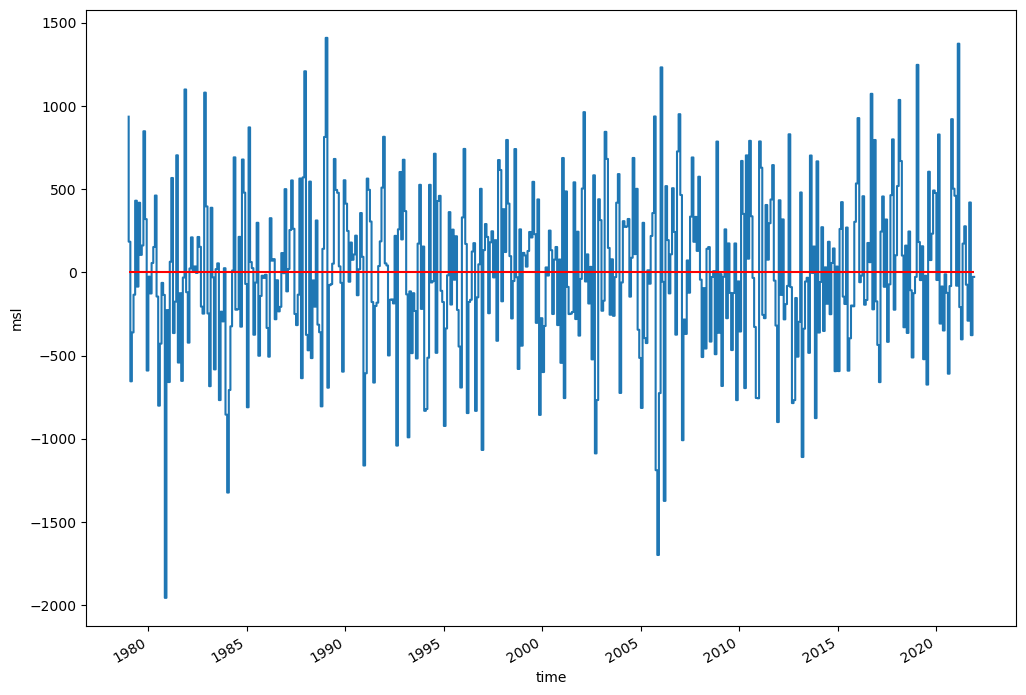

In [53]:
#prs1 = field.sel(lon=namelist[telecname]['lon1'],lat=namelist['NAO']['lat1'],method="nearest")
#prs2 = field.sel(lon=namelist[telecname]['lon2'],lat=namelist['NAO']['lat2'],method="nearest")

# Evaluating NAO

msl1 = field_an.sel(lon=lon1,lat=lat1,method='nearest')
msl2 = field_an.sel(lon=lon2,lat=lat2,method='nearest')

NAO = msl1-msl2

########
# Plot #
########

fig, ax = plt.subplots(figsize=(12, 8))

NAO.plot(ax=ax,ds='steps')
ax.hlines(y=0,xmin=min(NAO['time']),xmax=max(NAO['time']),color='red')

## Seasonal (3-months) average

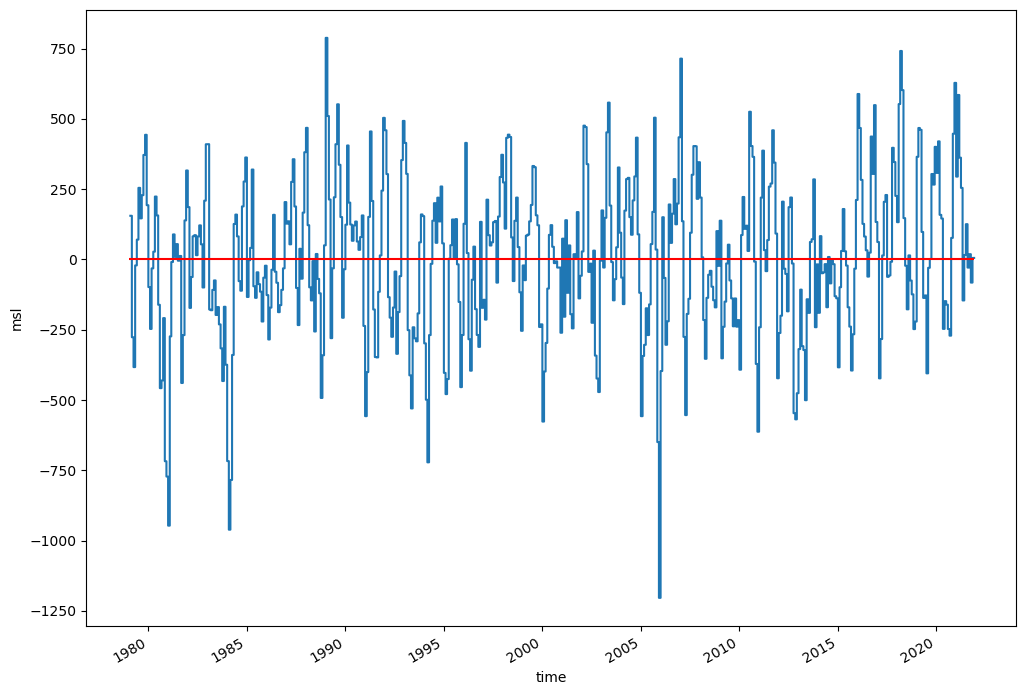

In [54]:
msl1_ma = msl1.rolling(time=3).mean() # to be generalized to data not gridded monthly
msl2_ma = msl2.rolling(time=3).mean()

NAO_ma = msl1_ma-msl2_ma

########
# Plot #
########

fig, ax = plt.subplots(figsize=(12, 8))

NAO_ma.plot(ax=ax,ds='steps')
ax.hlines(y=0,xmin=min(NAO_ma['time']),xmax=max(NAO_ma['time']),color='red')

## Index evaluation (3 months average)

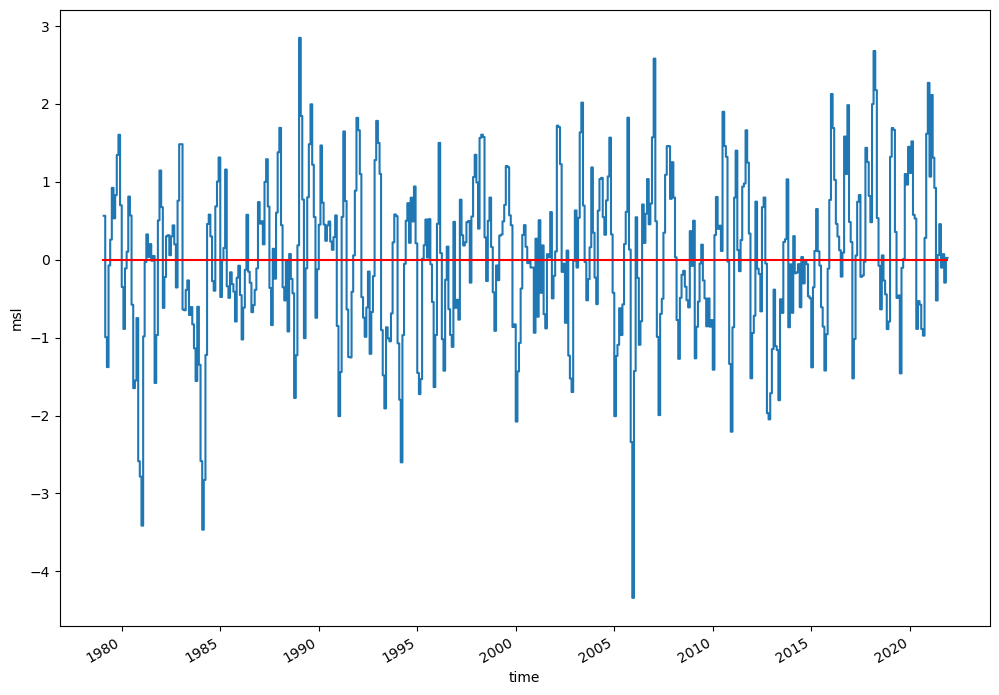

In [55]:
mean_ma = NAO_ma.mean()
std_ma  = NAO_ma.std()

NAO_ma_std = (NAO_ma-mean_ma)/std_ma

########
# Plot #
########

fig, ax = plt.subplots(figsize=(12, 8))

NAO_ma_std.plot(ax=ax,ds='steps')
ax.hlines(y=0,xmin=min(NAO_ma_std['time']),xmax=max(NAO_ma_std['time']),color='red')


## Different time selection

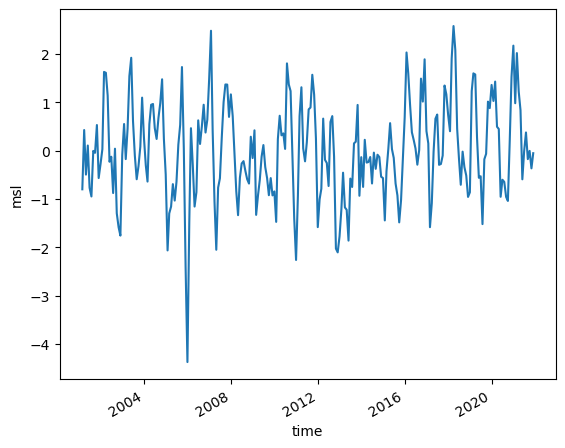

In [56]:
msl1_tsel = msl1.sel(time=msl1.time.dt.year>2000)
msl2_tsel = msl2.sel(time=msl2.time.dt.year>2000)

msl1_tsel = msl1_tsel.rolling(time=3).mean()
msl2_tsel = msl2_tsel.rolling(time=3).mean()

NAO_tsel = msl1_tsel-msl2_tsel

NAO_tsel_mean = NAO_tsel.mean()
NAO_tsel_std  = NAO_tsel.std()

indx_tsel = (NAO_tsel-NAO_tsel_mean)/NAO_tsel_std
indx_tsel.plot()

## Save output to .nc database

In [58]:
outfile = config[diagname]['output']
filename = '/NAO_indx.nc'
outfile = outfile+filename

NAO_ma_std.to_netcdf(outfile)

**Possible problem:** if the file already exists in the proposed path `to_netcdf` gives an error